In [ ]:
# Install external libraries
!pip install umap-learn
!pip install shap

# General libraries
import pandas as pd
import numpy as np
import os
import umap.umap_ as umap
import random as python_random
from scipy.stats import normaltest, pearsonr

# Google library
from google.colab import drive

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set seeds
umap_limit=1
seed_value=13
tf.random.set_seed(seed_value)
python_random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

# Check if gpu is enabled
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 24.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e6cac5e0c089e8bce8b2cc203a5d133060af68728bdb8a6a51b4a492ed4a288e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=57f3f91973b855eb0e03d432d6a6dc6ba51237115fd50f129aeb0e7755546eda
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 
Num GPUs Available:  1


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset**







In [ ]:
# Rosetta data
df_energy = pd.read_csv("data/binding-energy.csv", skiprows=1)

# Prodigy data
df_prodigy = pd.read_csv("data/PRODIGY_dataset.csv")

In [ ]:
# Remove 'SCORE:' and 'description' column
df_energy.drop(columns=['SCORE:', 'description'], axis=1, inplace=True)

# Add experimental binding energy from Prodigy at Rosetta data
df_energy = df_energy.join(df_prodigy["DG"])

In [ ]:
# Remove 'packstat' and 'yhh_planarity' because are constant
df_energy.drop(columns=['packstat', 'yhh_planarity'], axis=1, inplace=True)

df_energy.drop([28, 12, 14], axis=0, inplace=True)

# **Model Training**

In [ ]:
df_vhhs = pd.read_csv("data/vhhs2.csv")
df_vhhs.drop(columns=['description', 'packstat', 'yhh_planarity'], inplace=True)

df_train = df_energy.copy()
df_test = df_vhhs.copy()

In [ ]:
X = df_train.drop(columns=['DG'], axis=1) 
y = df_train["DG"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     random_state=seed_value,
                     shuffle=True)

In [ ]:
scaler = MinMaxScaler() 
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),
                      index=X_test.index, columns=X_test.columns)
                      

# UMAP Dimensionality Reduction
umap_dict = {}

for i in range(umap_limit):

    reducer = umap.UMAP(
        n_components=15, n_neighbors=20, random_state=42, transform_seed=42, verbose=False
    )

    X_t = reducer.fit_transform(X_train)
    X_t = pd.DataFrame(data=X_t, columns=[f"column_{i}" for i in range(X_t.shape[1])])

    X_te = reducer.transform(X_test)
    X_te = pd.DataFrame(data=X_te, columns=[f"column_{i}" for i in range(X_te.shape[1])])

    umap_dict[str(i)] = (X_t, X_te, reducer)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [ ]:
len(X_train.columns)

41

## Neural Network training

### Tune Neural Network Hyperparameters

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Square Error')
  plt.plot(hist['epoch'], np.sqrt(hist['mse']),
           label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mse']),
           label = 'Val Error')
  plt.ylim([0, 10])
  plt.legend()
  plt.show()

In [ ]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(4,kernel_initializer='he_uniform',
                        input_dim=X.shape[1],
                        activation='relu'))

    model.add(layers.Dense(10, kernel_initializer='he_uniform',
                           activation='relu'))
    model.add(layers.Dense(8 , kernel_initializer='he_uniform',
                           activation='relu'))
    model.add(layers.Dense(12 , kernel_initializer='he_uniform',
                           activation='relu'))                          
    model.add(layers.Dense(1, activation='linear',
                        kernel_initializer='uniform'))

    adam = tf.keras.optimizers.Adamax(learning_rate=0.01)

    model.compile(optimizer=adam,
                loss='mse',
                metrics=['mse'])

    return model

### Train Cross-validated Ensemble

Due to the stochastic nature of the algorithm or evaluation procedure,or differences in numerical precision. It is recommended to train the model a few times and take the avarage score.

Futhermore, we will train the models using a Kfolds and create a ensemble from them, this will reduce the risk of overfit.


Traning with fold 1


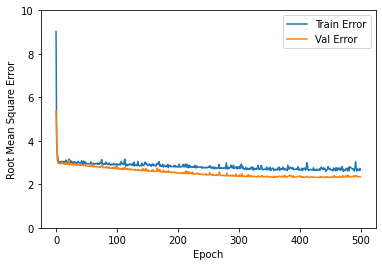


Traning with fold 2


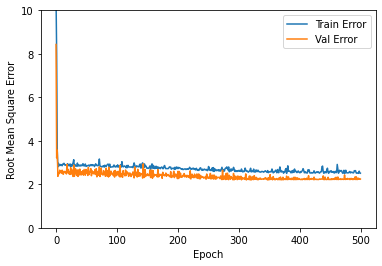


Traning with fold 3


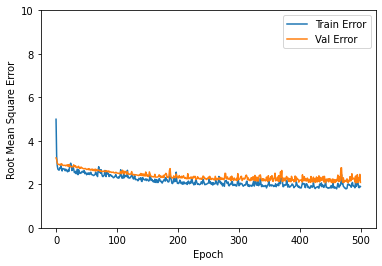


Traning with fold 4


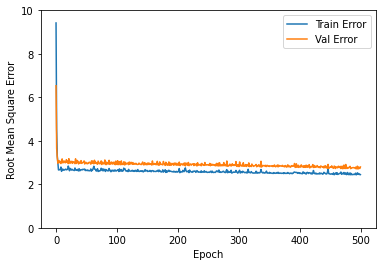


Traning with fold 5


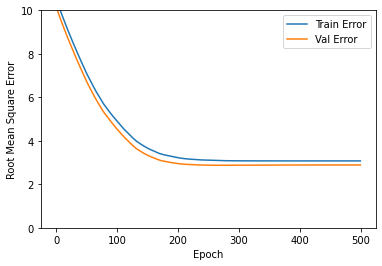


Traning with fold 6


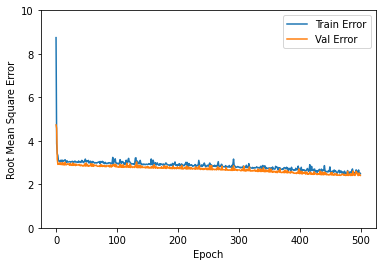


Traning with fold 7


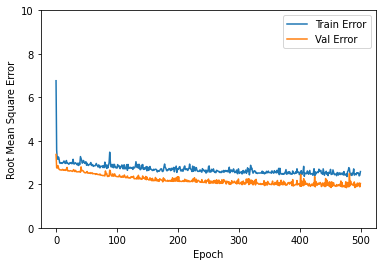


Traning with fold 8


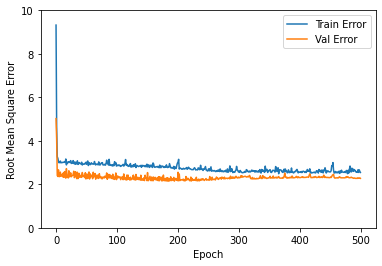


Traning with fold 9


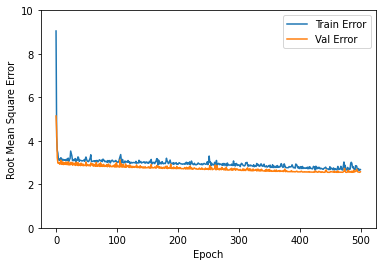


Traning with fold 10


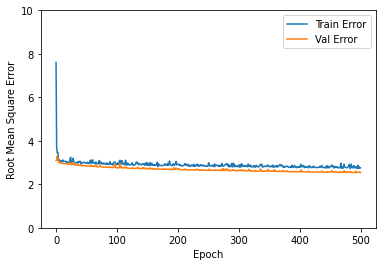

In [ ]:
def scheduler(epoch, lr):
    if epoch == 5:
        return lr * tf.math.exp(-0.1)
    elif epoch == 50:
        return lr * tf.math.exp(-0.1)
    elif epoch == 150:
        return lr * tf.math.exp(-0.1)
    else:
        return lr

models_dict = {}

with tf.device('/device:GPU:0'):
    for i in range(umap_limit):
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                             verbose=0)

        X = umap_dict[str(i)][0]
        Y = y_train
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed_value)

        models = []
        f_counter = 1

        for train, test in kfold.split(X, Y):
            model = build_model()
            print("\nTraning with fold {}".format(f_counter))
            history = model.fit(X.iloc[train], Y.iloc[train], 
                    validation_split=0.25,
                    epochs=500,
                    verbose=0,
                    batch_size=3,
                    validation_data=(umap_dict[str(i)][1], y_test),
                    callbacks=[reduce_lr],
                    shuffle=True)
            models.append(model)
            f_counter += 1
            plot_history(history)
        models_dict[str(i)] = models

In [ ]:
def get_predictions(df, models):
    results = []
    models_std = []
    
    for index, row in df.iterrows():
        r = np.expand_dims(row, axis=0)
        yhats = [m.predict(r)[0][0] for m in models]

        models_std.append(np.std(yhats))
        outcomes = np.mean(yhats)
        results.append(outcomes)

    return results, models_std


In [ ]:
X = umap_dict[str(0)][0]

test_predictions, std = \
    get_predictions(X, models_dict[str(0)])

b = []
for index, value in y_train.items():
    b.append(df_prodigy.iloc[index]["DG_pred"])

rmse = \
    np.sqrt(mean_squared_error(y_train, test_predictions, squared=True))
    
rmse_prodigy = \
    np.sqrt(mean_squared_error(y_train, b, squared=True))

print("RMSE score:", rmse)
print("RMSE score PRODIGY:", rmse_prodigy)
print("Pearson correlation experimental vs Prodigy:",
          pearsonr(y_train, b)[0])
print("Pearson correlation experimental vs ANN:",
          pearsonr(y_train, test_predictions)[0])

RMSE score: 2.4359037727330337
RMSE score PRODIGY: 2.0451387709866027
Pearson correlation experimental vs Prodigy: 0.7115249360522314
Pearson correlation experimental vs ANN: 0.5823386863907425


# **Test Scoring**

## Nanobodies

In [ ]:
for i in range(umap_limit):

    prodigy_score = pd.read_csv("data/prodigy_vhhs.csv")

    preds = []

    X_v = df_test.drop(columns=['DG'], axis=1).copy() 
    y_v = df_test["DG"].copy() 
    X_v = pd.DataFrame(scaler.transform(X_v),
                    index=X_v.index, columns=X_v.columns)

    u = umap_dict[str(i)][2]

    X_v = u.transform(X_v)
    X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

    test_predictions, std = \
        get_predictions(X_v, models_dict[str(i)])

    test = y_v.to_numpy()

    rmse = \
        np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
    rmse_prodigy = \
        np.sqrt(mean_squared_error(test, prodigy_score[' predicted'].to_numpy(), squared=True))

    print("RMSE score:", rmse)
    print("RMSE score PRODIGY:", rmse_prodigy)
    print("R2 score experimental vs ANN:",
          r2_score(test, test_predictions))
    print("R2 score experimental vs Prodigy:",
          r2_score(test, prodigy_score[' predicted'].to_numpy()))
    print("Pearson correlation experimental vs ANN:",
          pearsonr(test, test_predictions)[0])
    print("Pearson correlation experimental vs Prodigy:",
          pearsonr(test, prodigy_score[' predicted'].to_numpy())[0])

    preds.append((test_predictions, test))

    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    df_prodigy = prodigy_score[' predicted']
    df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
    df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
    print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 1.6608713758151015
RMSE score PRODIGY: 2.4302215790081614
R2 score experimental vs ANN: 0.1746893040795512
R2 score experimental vs Prodigy: -0.7670027220878588
Pearson correlation experimental vs ANN: 0.45526635921474173
Pearson correlation experimental vs Prodigy: 0.18083371360752964

DF COMPARISON:
      REAL  PREDICTED   P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.17  -9.594413 -0.575587    -11.6           1.43
1  -12.17 -11.440682 -0.729318     -9.8          -2.37
2  -11.65 -12.027384  0.377384     -9.6          -2.05
3  -13.80 -11.755001 -2.044999    -12.5          -1.30
4  -10.91 -11.628304  0.718304    -11.3           0.39
5   -8.90 -10.577158  1.677158    -10.6           1.70
6  -12.08  -9.072355 -3.007645     -9.3          -2.78
7  -12.75 -11.851103 -0.898897    -10.5          -2.25
8  -12.59 -10.588088 -2.001912     -8.1          -4.49
9  -10.19 -10.000656 -0.189344     -8.8          -1.39
10 -12.17 -12.313190  0.143190    -10.6          -1.57
11  -9.85  -9.963980  0.

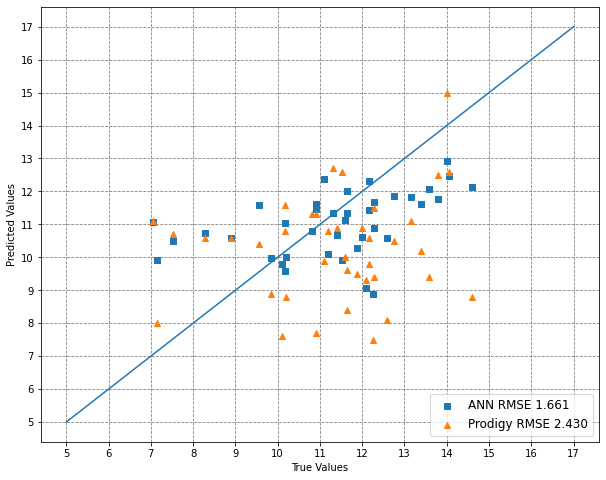

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(prodigy_score[' predicted'].to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.show()

## PDBind

In [ ]:
for i in range(umap_limit):

    PDBind_df = pd.read_csv("data/benchmark/validation.csv")
    PDBind_prodigy = pd.read_csv("data/benchmark/prodigy_PDBind.csv")

    # Remove pdb that wasn't accepted by prodigy
    PDBind_df.drop([24], axis=0, inplace=True)
    PDBind_prodigy.drop([24], axis=0, inplace=True)
    PDBind_df = PDBind_df.reset_index(drop=True)
    PDBind_prodigy = PDBind_prodigy.reset_index(drop=True)

    preds = []

    X_v = PDBind_df.drop(columns=['experimental',
                                  'packstat',
                                  'SCORE:',
                                  'yhh_planarity',
                                  'description'], axis=1).copy() 
    y_v = PDBind_df["experimental"].copy() 
    X_v = pd.DataFrame(scaler.transform(X_v),
                    index=X_v.index, columns=X_v.columns)

    u = umap_dict[str(i)][2]

    X_v = u.transform(X_v)
    X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

    test_predictions, std = \
        get_predictions(X_v, models_dict[str(i)])

    test = y_v.to_numpy()

    rmse = \
        np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
    rmse_prodigy = \
        np.sqrt(mean_squared_error(test, PDBind_prodigy['predicted'].astype(float).to_numpy(), squared=True))

    print("RMSE score:", rmse)
    print("RMSE score PRODIGY:", rmse_prodigy)
    print("R2 score experimental vs ANN:",
          r2_score(test, test_predictions))
    print("R2 score experimental vs Prodigy:",
          r2_score(test, PDBind_prodigy['predicted'].astype(float).to_numpy()))
    print("Pearson correlation experimental vs ANN:",
          pearsonr(test, test_predictions)[0])
    print("Pearson correlation experimental vs Prodigy:",
          pearsonr(test, PDBind_prodigy['predicted'].astype(float).to_numpy())[0])
    
    preds.append((test_predictions, test))

    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    df_prodigy = PDBind_prodigy['predicted'].astype(float)
    df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
    df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
    print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 2.4459716251742734
RMSE score PRODIGY: 3.586044094109546
R2 score experimental vs ANN: -0.6252807183680975
R2 score experimental vs Prodigy: -2.4934682819686396
Pearson correlation experimental vs ANN: -0.11466359271399248
Pearson correlation experimental vs Prodigy: -0.08264119899508117

DF COMPARISON:
      REAL  PREDICTED   P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.50  -9.787905 -0.712095     -9.4          -1.10
1   -8.31 -10.572384  2.262384     -6.8          -1.51
2  -10.25  -8.015894 -2.234106     -7.3          -2.95
3   -9.17 -12.005278  2.835278    -13.4           4.23
4  -11.92 -12.037804  0.117804    -15.6           3.68
5   -8.95 -11.168412  2.218412     -7.7          -1.25
6   -9.55  -9.265936 -0.284064    -11.1           1.55
7  -10.85 -11.065532  0.215532    -10.8          -0.05
8  -10.89 -10.026043 -0.863957     -7.7          -3.19
9  -13.06 -11.632001 -1.427999    -17.1           4.04
10 -11.31 -11.444609  0.134609    -12.7           1.39
11  -7.05 -12.695560  

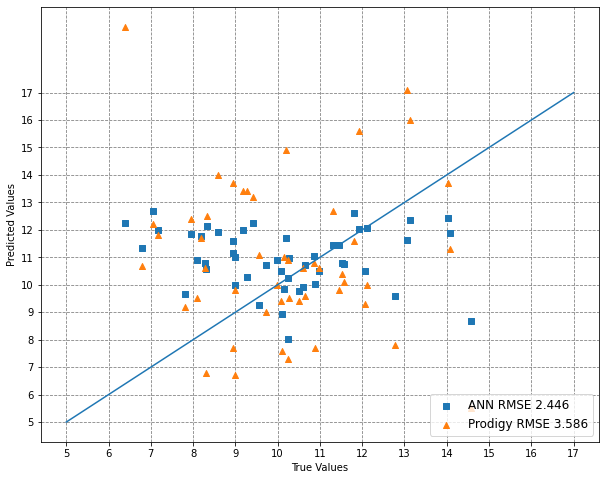

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(PDBind_prodigy['predicted'].astype(float).to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


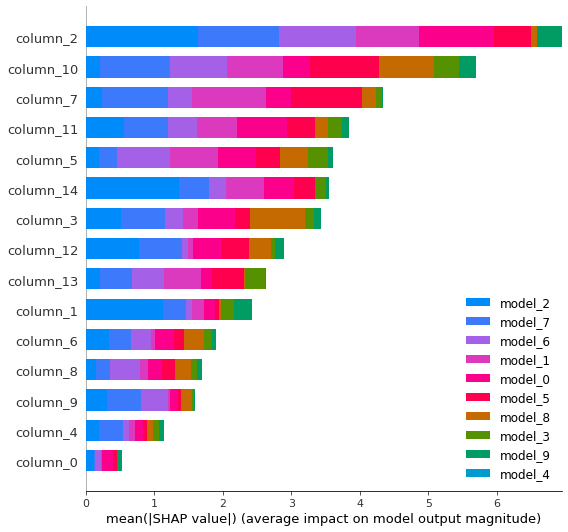

In [ ]:
import shap

n_models = 10

values = None

for i in range(n_models):
    model_ = models_dict["0"][i]


    explainer = shap.DeepExplainer(model_, umap_dict["0"][0].to_numpy())
    shap_values = explainer.shap_values(umap_dict["0"][1].to_numpy())

    values = shap_values if values is None else values + shap_values

shap.summary_plot(values, plot_type = 'bar', feature_names = umap_dict["0"][1].columns, class_names=[f"model_{i}" for i in range(n_models)])

In [ ]:
components = umap_dict["0"][1].columns

shap_dict = {}

for i in range(n_models):
    rf_resultX = pd.DataFrame(values[i], columns = components)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(components, vals)),
                                    columns=['col_name','feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False, inplace=True)
    
    shap_dict[i] = shap_importance

shap_df = shap_dict[0]

for i in range(1, n_models):
    shap_df['feature_importance_vals'] += shap_dict[i]["feature_importance_vals"]

shap_df['feature_importance_vals'] /= n_models

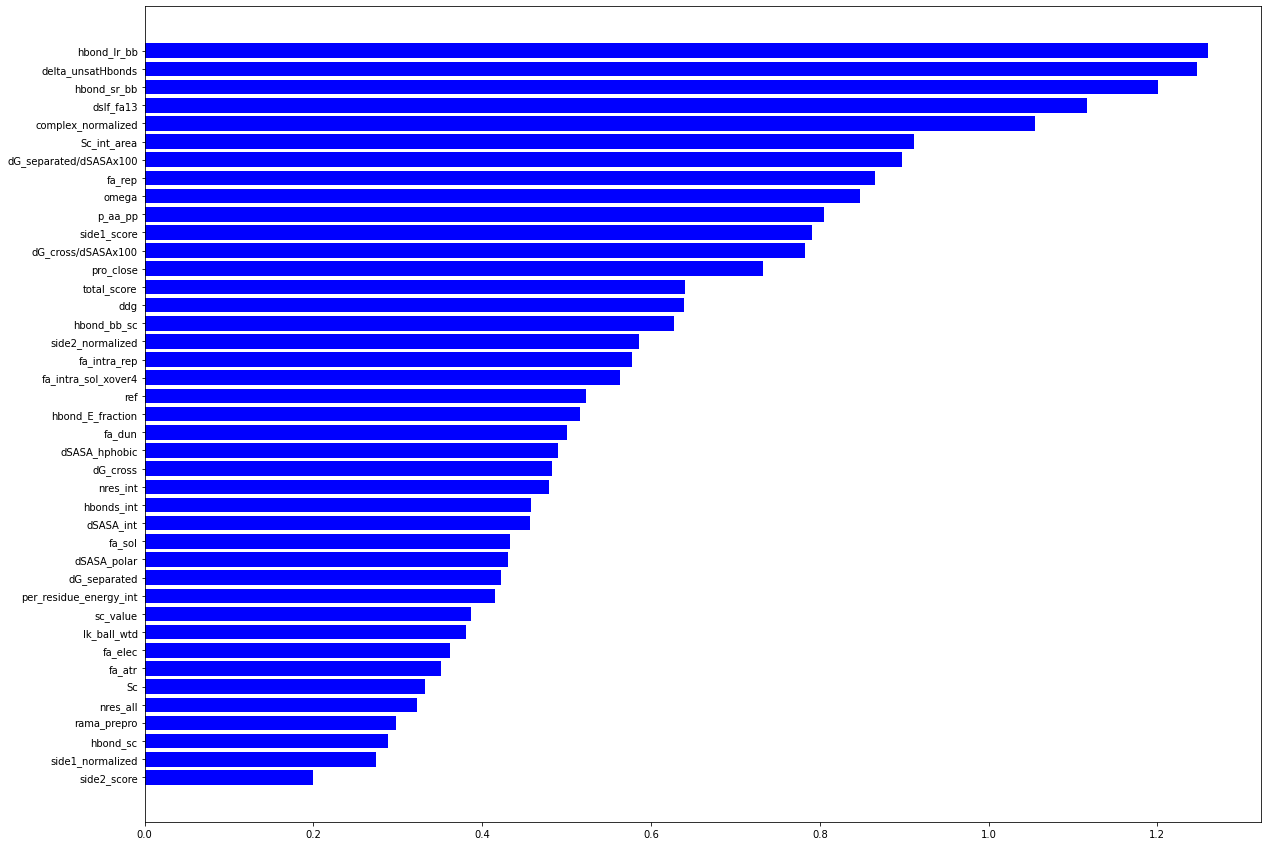

In [ ]:
features = X_train.columns

corr = pd.concat([X_train,
                 umap_dict["0"][0]],
                 axis=1).corr()

final_values = {}

for f in features:
    s = .0
    for c in components:
        score = shap_df[shap_df["col_name"] == c]
        s += score["feature_importance_vals"].iloc[0] * abs(corr[f][c])
    final_values[f] = s

sorted_dict = {}
sorted_keys = sorted(final_values, key=final_values.get, reverse=True)

for w in sorted_keys:
    sorted_dict[w] = final_values[w]

plt.figure(figsize=(20, 15))
plt.barh(list(sorted_dict.keys()), sorted_dict.values(), color='b')
plt.gca().invert_yaxis()
plt.show()